In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from data import *
from utils import *
from NMF import *
import time
import pandas as pd
import seaborn
from copy import deepcopy

2023-03-03 14:12:31.647939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martilud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from NMF import *


NMF_sep_unit_tests()

Exemplar-based fitting OK
Standard fitting OK
Adversarial fitting OK
Discriminative fitting OK
Full fitting OK


Convergence experiment
---

We generate data, $2500$ of all types of data, with $0$ and $1$ digits. We select deterministic weights equal to $1/2$, and preselect $d = 32$. We do all experiments with the same data. The loss we show is the respective loss of the different methods. For all methods, we only show convergence of the first source. For ANMF we select the batch size of the adversarial data to be $100$ for all experiments. 

In [2]:
np.random.seed(0)
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_adv = 2500
N_sup = 2500
N_V = 2500
N_sup_test = 0
mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
U_r = []
for i in range(M):
    U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)

In [3]:
# Convergence of NMF 
np.random.seed(0)
plt.rcParams.update({'font.size': 14})

batch_size = [50,500,1000,2500]
linestyles = ['dashdot']*10
times = []
loss_stds = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf = NMF(d = 32, epochs = 100, batch_size = b, mu_W = 1e-10, mu_H = 1e-10, normalize = True)
    loss_stds.append(nmf.fit_std(U_r = U_sup[0],conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[4.366192817687988, 2.4146921634674072, 2.1119179725646973, 2.4722981452941895]


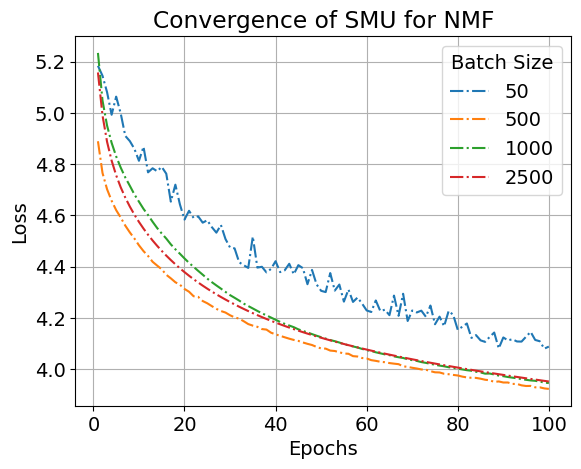

In [4]:
for i,b in enumerate(batch_size): 
    plt.plot(np.arange(1,101), loss_stds[i][1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title(f"Convergence of SMU for NMF")
plt.grid()
plt.savefig("fig/std_conv.png")
plt.show()

In [3]:
# Convergence of Adversarial NMF
plt.rcParams.update({'font.size': 14}) 
np.random.seed(0)

batch_size = [500,1000,2500]
batch_size_z = [100,100,5000]
linestyles = ['dashdot']*10
times = []
loss_advs = []

for i,b in enumerate(batch_size):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [32,32], epochs = 100, prob = "adv", true_sample = "std", normalize = False, update_H = True,
        mu_W = 1e-6, mu_H = 1e-6, batch_size = batch_size[i], batch_size_z = batch_size_z[i], tau_A = 0.05)
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_advs.append(nmf_sep.NMFs[0].fit_adv(U_r = U_sup[0], U_z = U_z[0], conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)


[7.151650905609131, 5.834007978439331, 8.725145101547241]


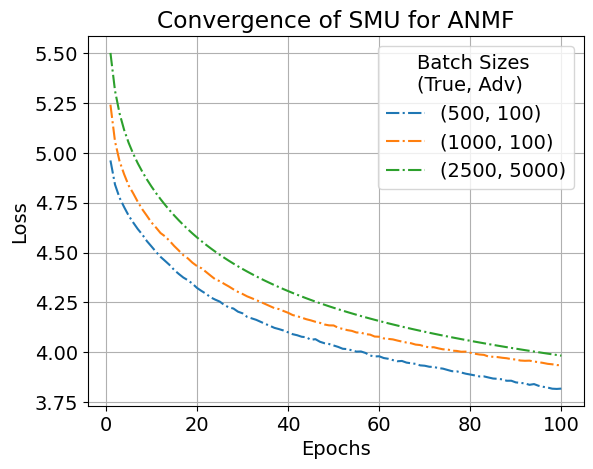

In [9]:
for i, b in enumerate(batch_size): 
    plt.plot(np.arange(1,len(loss_advs[i])), loss_advs[i][1:],label = f"({b}, {batch_size_z[i]})", linestyle = linestyles[i])
plt.legend(title = r"Batch Sizes " + "\n" + "(True, Adv)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for ANMF")
plt.grid()
plt.savefig("fig/adv_conv.png")
plt.show()


In [5]:
# Convergence of discriminative NMF
plt.rcParams.update({'font.size': 14}) 

#batch_sizes = [100, 250, 1250, 2500]
batch_size = [50,500,1000,2500]
linestyles = ['dashdot']*10
ds = [32,32]
times = []
loss_sups = []
for i,b in enumerate(batch_size):
    tick = time.time()
    nmf = NMF(d = np.sum(ds), ds = ds, epochs = 100, mu_W = 1e-10, mu_H = 1e-10, batch_size_sup = b, normalize = True, update_H = False)
    loss_sups.append(nmf.fit_sup(U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
print(times)

[10.587131977081299, 5.901862859725952, 4.655087947845459, 5.644517183303833]


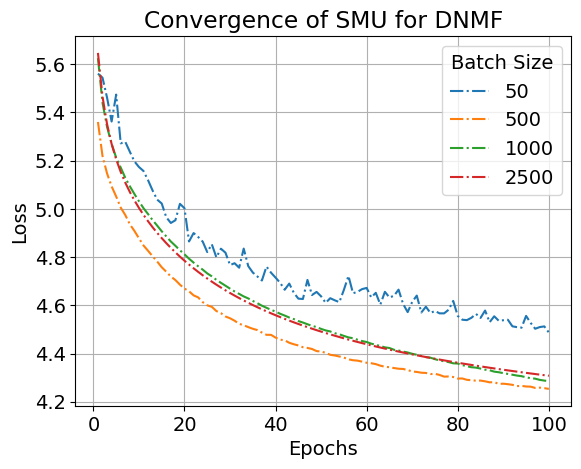

[10.587131977081299, 5.901862859725952, 4.655087947845459, 5.644517183303833]


In [6]:
for i, b in enumerate(batch_size):
    plt.plot(np.arange(1,101),loss_sups[i][0,1:],label = f"{b}", linestyle = linestyles[i])
plt.legend(title = "Batch Size", loc = "upper right")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for DNMF")
plt.grid()
plt.savefig("fig/sup_conv.png")
plt.show()

print(times)

In [150]:
# Convergence of full NMF
plt.rcParams.update({'font.size': 14}) 

batch_size_r = [50, 500, 1000,2500]
batch_size_z = [50, 100, 100, 2500]
batch_size_sup = [50, 500, 1000, 2500]
linestyles = ['dashdot']*10
ds = [32,32]
times = []
loss_fulls = []
for i,b in enumerate(batch_size_r):
    tick = time.time()
    nmf_sep = NMF_separation(ds = [32,32], epochs = 100, mu_W = 1e-10, mu_H = 1e-10, prob = "full",
        batch_size = batch_size_r[i], batch_size_z = batch_size_z[i], batch_size_sup = batch_size_sup[i], tau_A = 0.05, tau_S = 0.5,
        true_sample = "sup")
    U_z = nmf_sep.create_adversarial(U_sup, V_sup)
    loss_fulls.append(nmf_sep.NMF_concat.fit_full(U_r = U_sup, U_z = U_z, U_sup = U_sup, V_sup = V_sup, conv = True))
    tock = time.time()
    times.append(tock-tick)
    

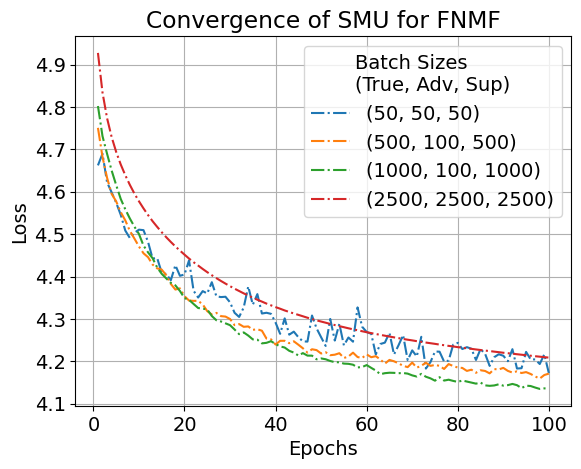

[30.630742073059082, 27.38480496406555, 24.607407093048096, 24.30902123451233]


In [151]:
for i, b in enumerate(batch_size):
    plt.plot(np.arange(1,101),loss_fulls[i][0,1:],label = f"({b}, {batch_size_z[i]}, {batch_size_sup[i]})", linestyle = linestyles[i])
plt.legend(title = "Batch Sizes" + '\n' + "(True, Adv, Sup)")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Convergence of SMU for FNMF")
plt.grid()
plt.savefig("fig/full_conv.png")
plt.show()


print(times)

Fix the update so that it divides by the correct batch size. Why is it behaving randomly?

We see that for all methods converge, and smaller batch sizes tend to yield faster convergence. Selecting the batch sizes too small can lead to slower convergence and too much randomness. It is also interesting to see that standard NMF converges to a smaller loss than DNMF, because DNMF. This is to be expected as DNMF has to fit the basises while also splitting mixed data, while standard NMF only has to learn bases.


Data rich experiment
---

In this experiment we want to test the proposed methods in a setting where we have a lot of both weak and strong supervised data to see how the data settings compare. We test this on $0$ and $1$ digits, as NMF performs relatively well in this situation. We select $2500$ of each source, $2500$ mixed data and $2500$ strong supervised data. The mixed data is generated so that none of the mixed images are the same as the source images. In other words, no observed data from $\mathbb{P}_{U_i}$ is used to generate observed data from $\mathbb{P}_V$.


In [2]:
# Parameters for experiment
np.random.seed(0)
number_of_experiments = 1
M = 2
Ms_all = [0,1]
N_adv = 1000
N_sup = 5000
N_sup_test = 1000
mu_W = 1e-6
mu_H = 1e-6

epochs_std = 50
epochs = 50
test_epochs = 100
batch_size = 500
batch_size_sup = 500
batch_size_z = 100
wiener = True

Ds = [16,32,48,64,96]

probs = ["std", "adv","sup","exem"]

dfs = []
for i in range(len(probs)):
    dfs.append(pd.DataFrame(columns=[ "norm_means", "norm_stds","psnrs", "psnr_means", "psnr_stds"]))
meta_df = pd.DataFrame(columns=["Ms"])

df = pd.DataFrame(columns = ["id", "d", "prob", "mean_psnrs"])

taus = [0.0, 0.05, 0.0,0.0]


for ex in range(number_of_experiments):
    Ms = np.random.choice(Ms_all, M, replace = False)

    # Generate data
    mnist = MNIST()
    #mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    #U_r = []
    #for i in range(M):
    #    U_r.append(np.copy(mnist.x_r_train[i].reshape((mnist.Ns_adv[i],784)).T))
    #V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, pytorch = False, type = "det", weights = [1.0/M] * M)
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])

    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)

    # arrays to store results
    # Each problem, each source, each data
    norms = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
    norm_means = np.zeros((len(probs), M, len(Ds))) 
    norm_stds = np.zeros((len(probs), M, len(Ds)))
    psnrs = np.zeros((len(probs), M, len(Ds), N_sup_test)) 
    mean_psnrs = np.zeros((len(probs), M, len(Ds)))
    std_psnrs = np.zeros((len(probs), M, len(Ds)))

    seps = []
    for j,d in enumerate(Ds):
        for i, prob in enumerate(probs):
            print(prob)

            # Fit
            sep = NMF_separation(ds = [d] * M, tau_A = taus[i], normalize = True, update_H = False, true_sample = "std",
                epochs = epochs_std if prob == "std" else epochs,prob = prob, 
                mu_W = mu_W, mu_H = mu_H, test_epochs = test_epochs, wiener = True,
                batch_size = batch_size, batch_size_z = batch_size_z, batch_size_sup = batch_size_sup)

            # Use standard NMF as initial conditions
            if prob == "adv" or prob == "sup":
                for k in range(M):
                    sep.NMFs[k].W = np.copy(stdWs[k])
            
            sep.fit(U_r = U_sup, V = V_sup, U_sup = U_sup, V_sup = V_sup)

            if prob == "std":
                stdWs = []
                for k in range(M):
                    stdWs.append(sep.NMFs[k].W)


            # Separate
            out = sep.separate(V_test)

            # Measure quality SHOULD USE eval member function of sep
            psnrs[i,:,j,:] = PSNR(U_test,out)

            df = pd.concat([df, pd.DataFrame({"d": [d]*N_sup_test, "id": np.arange(0,N_sup_test), "prob": [prob]*N_sup_test, "mean_psnrs": np.mean(psnrs[i,:,j,:],axis = 0)})])
            seps.append(deepcopy(sep))


std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem
std
adv
sup
exem


In [3]:
df.to_csv('data_rich.csv')

In [4]:
data_rich_df = pd.read_csv('data_rich.csv', index_col = 0)

/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_42636/4091125012.py:7: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x13f9913a0> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels = ["Standard NMF", "_nolegend_" , "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Exemplar NMF"])
/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_42636/4091125012.py:7: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x13f991af0> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels = ["Standard NMF", "_nolegend_" , "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Exemplar NMF"])
/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_42636/4091125012.py:7: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x13f991f70> starts with '_'. It is thus excluded from the legend.
  plt.leg

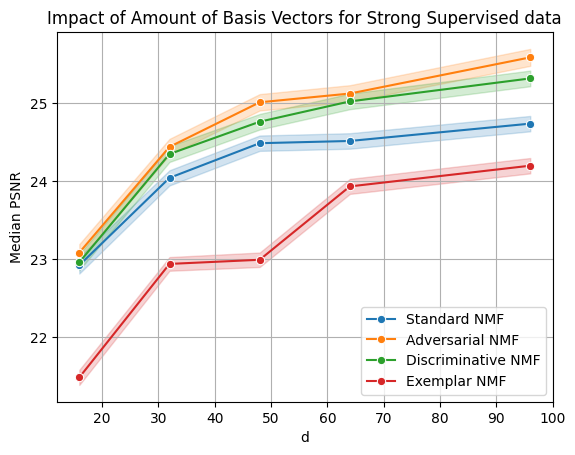

In [5]:
plt.rcParams.update({'font.size': 10}) 
seaborn.lineplot(data_rich_df, x = "d", y = "mean_psnrs", hue = "prob", 
    estimator = "median", errorbar = "se", markers = True, dashes = True ,
    marker = 'o',legend=False)
plt.grid()
plt.ylabel("Median PSNR")
plt.legend(labels = ["Standard NMF", "_nolegend_" , "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Exemplar NMF"])
plt.title("Impact of Amount of Basis Vectors for Strong Supervised data")
plt.savefig("Data_rich.pdf")
plt.show()

In [6]:
seps_ = seps[16:20]
for sep in seps_:
    sep.wiener = True

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test[:,:], "psnr")
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test[:,:], "psnr")
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test[:,:], "psnr")
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test[:,:], "psnr")

out_std = seps_[0].separate(V_test[:,:])
out_adv = seps_[1].separate(V_test[:,:])
out_sup = seps_[2].separate(V_test[:,:])
out_exem = seps_[3].separate(V_test[:,:])

diff_adv = []

for i in range(len(psnrs_std)):
    diff_adv.append(psnrs_adv[i]-psnrs_std[i])

ids = np.argsort(diff_adv)
print(ids)

psnrs_std = seps_[0].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_adv = seps_[1].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_sup = seps_[2].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)
psnrs_exem = seps_[3].eval(U_test[:,:,:], V_test[:,:], "psnr", aggregate = None)


[633 757 171 237 173 708  81 651 578 258  62 761 850 148 193 714 827  79
 427  96 639  72 425 538 450 445 249 930 374  93   4 497 166 101 738  58
  95 381 463 378 833 480 777 485 248 337 443 936 332  65 940  14 541 909
 106 974 769 156 700  16 767 104 983 981 956 207 635 723 510 105 638 363
 931 772 196 826 937 268 684 899 882 737 142 706 379 801 963 370 504 829
 482 123 120 900 464 702 137 760 836 459 671 676 805 507 163  50 705 119
 773 111 186 481 715 516 759 345 319  11 161 984 948 455 628 870  84 487
 160 884  55 831 552 755 528 493 288 103 261 525 821 993 202 535 885 509
 475 469 228 782 877 325 384 266  43 357 807 557 143 360 254  88 498 626
 191  83 734 968 144 460 549 282  10 331 210 126 735 997   1 359 399 390
 291  36 577 880 128 840 407 224 271 819 925 643 139  37 961 246 437 527
 274 414 894 960  51 534 342 398 905 729 703 864 815   9 175 732 674 945
  69 907 267 352 661 368 366 233 206 348  94 548  12 451 686 563 596 518
 657 322 969   2 896 295 566 184 972  21 154 164 43

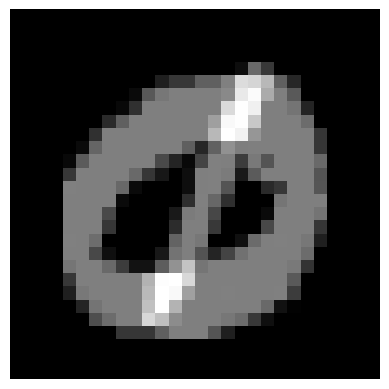

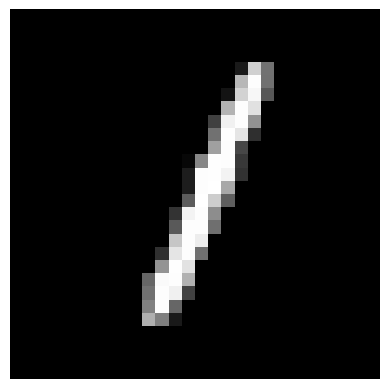

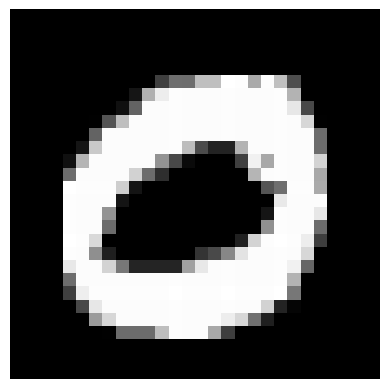

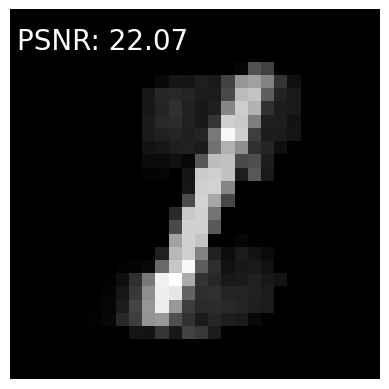

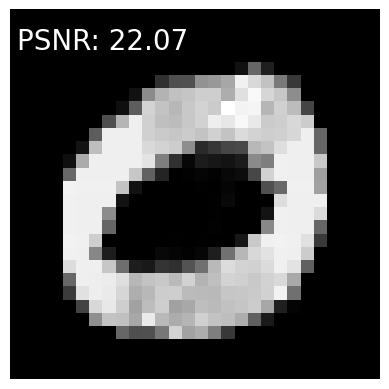

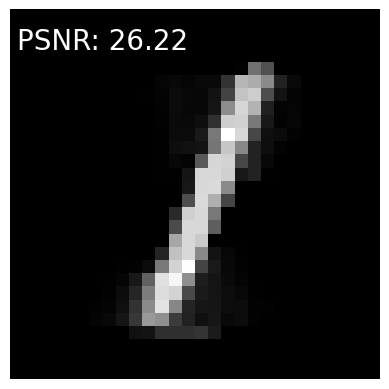

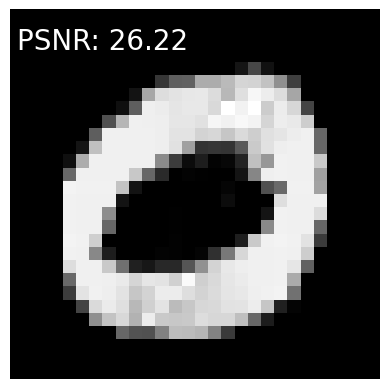

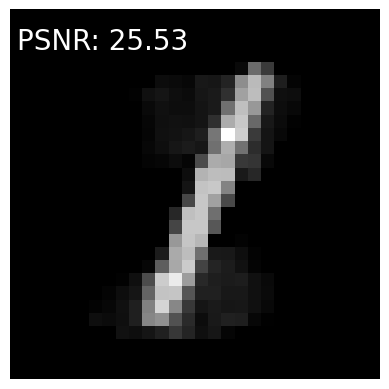

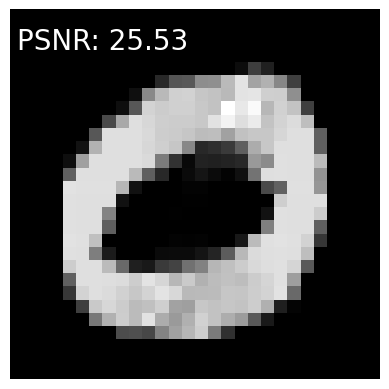

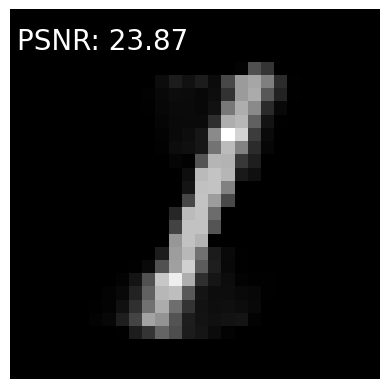

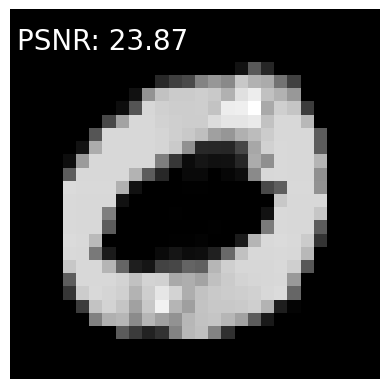

In [7]:
id = 361 # 361
vmin = 0
vmax = 0.5



plt.imshow(V_test[:,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/v.png', bbox_inches = "tight")
plt.show()


plt.imshow(U_test[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u0.png', bbox_inches = "tight")
plt.show()


plt.imshow(U_test[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
plt.axis('off')
plt.savefig('fig/u1.png', bbox_inches = "tight")
plt.show()


fig, ax = plt.subplots()
ax.imshow(out_std[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_std[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_std.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_std[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_std_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_adv[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_adv.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_adv[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_adv_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_sup[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u0_sup.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_sup[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_sup_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,0,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[0,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u1_exem_psnr.png', bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.imshow(out_exem[:,1,id].reshape((28,28)), cmap = "gray", vmin = vmin)
ax.axis('off')
plt.savefig('fig/u1_exem.png')
ax.text(0.02, 0.95, "PSNR: {:.2f}".format(psnrs_exem[1,id]),
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        color='white', fontsize = 20)
plt.savefig('fig/u0_exem_psnr.png', bbox_inches = "tight")
plt.show()




Performance is relatively similar each run, but there is som variance depending on the data. Almost every time ANMF performs just slightly worse than DNMF. The gap between standard NMF and the improved methods is not that large, almost 1 dB at most. In imaging applications this is somewhat significant. It is important here to select enough data, or the methods will perform a lot more similar. If we select digits ANMF perform much worse, but we have seen from tuning experiments that it can still outperform standard NMF. ENMF performs poorly unless $d$ is very large.

Now want to extract sample images that illustrates how the different methods work:

DO


In [53]:
#np.random.seed(0)
mnist = MNIST()
Ms = [0,1]
M = len(Ms)
N_adv = 400
N_sup = 200
N_V = 400
N_sup_test = 1000

mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
U_r = []
for i in range(M):
    U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)

mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)

V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
U_sup = []
U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
U_test_fit = []
for i in range(M):
    U_sup.append(U_s[:,i,:])
    U_test_fit.append(U_test[:,i,:])
V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)

d_dict = {"name": 'ds', "dist": lambda: [64, 64]}
normalize_dict = {"name": 'normalize', "dist": lambda: True}#np.random.choice([True,False], replace = True)}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(1,30)}
test_epochs_dict = {"name": 'test_epochs', "dist": lambda: np.random.randint(100,150)}
batch_size_r_dict = {"name": 'batch_size', "dist": lambda: np.random.choice([200,400], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([100,200,400], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([100], replace = True)}
true_sample_dict = {"name": 'true_sample', "dist": lambda: np.random.choice(["std","sup"], replace = True)}
#wse_dict = {"name": 'warm_start_epochs', "dist": lambda: np.random.randint(1,20)}
tau_A_dict = {"name": 'tau_A', "dist": lambda: 0.3*np.random.beta(1.0,2.0)}
tau_S_dict = {"name": 'tau_S', "dist": lambda: np.random.uniform(0.0,0.5)}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.5,1.0), np.random.uniform(0.5,1.0)]} 
Ws_dict = {"name": 'Ws', "dist": lambda: Ws}

prob_dict = {"name": 'prob', "dist" : lambda: "adv"}

param_dicts = [d_dict, 
    normalize_dict,
    mu_H_dict, 
    prob_dict, 
    mu_W_dict, 
    epochs_dict, 
    test_epochs_dict,
    batch_size_r_dict, 
    batch_size_z_dict, 
    batch_size_sup_dict,
    #wse_dict, 
    tau_A_dict,
    tau_S_dict,
    true_sample_dict,
    betas_dict,
    Ws_dict,
]

rs = random_search(NMF_separation, param_dicts, N_ex = 20, cv = 0, source_aggregate = "mean", data_aggregate = "median")

results = rs.fit(U_r = U_r, V = V, U_sup = U_sup, V_sup = V_sup)

#Ws = [np.copy(rs.best_model.NMFs[0].W),np.copy(rs.best_model.NMFs[1].W)]




In [54]:
print(np.median(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))
print(rs.best_param)

24.635013893980915
{'ds': [64, 64], 'normalize': True, 'mu_H': 2.2163180794322908e-06, 'prob': 'adv', 'mu_W': 5.525354035394307e-08, 'epochs': 25, 'test_epochs': 142, 'batch_size': 400, 'batch_size_z': 400, 'batch_size_sup': 100, 'tau_A': 0.025494294408326745, 'tau_S': 0.04750745090522318, 'true_sample': 'sup', 'betas': [0.8447639484449284, 0.858372959101778], 'Ws': [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]}


In [55]:
df = pd.DataFrame(results)
df.head()
print(rs.best_param)

{'ds': [64, 64], 'normalize': True, 'mu_H': 2.2163180794322908e-06, 'prob': 'adv', 'mu_W': 5.525354035394307e-08, 'epochs': 25, 'test_epochs': 142, 'batch_size': 400, 'batch_size_z': 400, 'batch_size_sup': 100, 'tau_A': 0.025494294408326745, 'tau_S': 0.04750745090522318, 'true_sample': 'sup', 'betas': [0.8447639484449284, 0.858372959101778], 'Ws': [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]}


In [56]:
"""
BIG NUMERICAL EXAMPLE WITH RANDOM SEARCH
- Test for different M
- Test all models by first selecting optimal exemplar based -> Use W in std -> use W in adv, sup and full
- Record the difference in PSNR between the different methods and the std method
- Store results in dictionary/DataFrame
"""
np.random.seed(0)
number_of_experiments = 9
number_of_searches = 20
M = 2
Ms_all = [0,2,3,4,5,6,7,8,9]
N_adv = 400
N_V = 400
N_sup = 200
N_sup_test = 1000

d_dict = {"name": 'ds', "dist": lambda: [64, 64]}
normalize_dict = {"name": 'normalize', "dist": lambda: True}
mu_H_dict = {"name": 'mu_H', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
mu_W_dict = {"name": 'mu_W', "dist": lambda: np.power(10,np.random.uniform(-10,-3))}
epochs_dict = {"name": 'epochs', "dist": lambda: np.random.randint(5,50)}
test_epochs_dict = {"name": 'test_epochs', "dist": lambda: np.random.randint(100,150)}
batch_size_r_dict = {"name": 'batch_size', "dist": lambda: np.random.choice([200,400], replace = True)}
batch_size_z_dict = {"name": 'batch_size_z', "dist": lambda: np.random.choice([50,100,200], replace = True)}
batch_size_sup_dict = {"name": 'batch_size_sup', "dist": lambda: np.random.choice([100], replace = True)}
true_sample_dict = {"name": 'true_sample', "dist": lambda: np.random.choice(["std", "sup"], replace = True)}
tau_A_dict = {"name": 'tau_A', "dist": lambda: 0.3 * np.random.beta(1.0,1.5)}
tau_S_dict = {"name": 'tau_S', "dist": lambda: np.random.uniform(0.0,0.5)}
betas_dict = {"name": 'betas', "dist": lambda: [np.random.uniform(0.5,1.0), np.random.uniform(0.5,1.0)]} 

probs = ["exem", "std", "adv", "sup", "full"]
results = {"M": [], "exem" : [], "std" : [], "adv" : [], "sup" : [], "full": []}

for i in range(number_of_experiments):
    print(i)

    mnist = MNIST()

    Ms = [1,i + (i>=1)]

    mnist.generate_adverserial(Ms = Ms, Ns = [N_adv]*M, N_V = N_V, type = "det", weights = [1.0/M]*M)
    U_r = []
    for i in range(M):
        U_r.append(np.copy(mnist.x_r_train[i][:,:,:].reshape((mnist.Ns_adv[i],784)).T))
    V = np.copy(mnist.x_v_train.reshape((mnist.N_adv_V,784)).T)
    
    mnist.generate_supervised(Ms = Ms, N_sup = N_sup, N_sup_test = N_sup_test, type = "det", weights = [1.0/M] * M)
    
    V_sup = np.copy(mnist.x_sup_train[:,0,:,:].reshape((mnist.N_sup, 784)).T)
    U_s = np.copy(mnist.y_sup_train.reshape((mnist.N_sup,M,784)).T)
    U_sup = []
    U_test = np.copy(mnist.y_sup_test.reshape((mnist.N_sup_test,M,784)).T)
    U_test_fit = []
    for i in range(M):
        U_sup.append(U_s[:,i,:])
        U_test_fit.append(U_test[:,i,:])
    V_test = np.copy(mnist.x_sup_test[:,0,:,:].reshape((mnist.N_sup_test, 784)).T)

    results["M"].append(i + (i>=1))

    for prob in probs:

        prob_dict = {"name": 'prob', "dist": lambda: prob}

        if prob == "exem":
            W_dict = {"name": 'Ws', "dist": lambda: None}

        param_dicts = [d_dict, 
            normalize_dict,
            mu_H_dict, 
            prob_dict, 
            mu_W_dict, 
            epochs_dict, 
            test_epochs_dict,
            batch_size_r_dict, 
            batch_size_z_dict, 
            batch_size_sup_dict,
            tau_A_dict,
            tau_S_dict,
            true_sample_dict,
            betas_dict,
            W_dict,
        ]

        rs = random_search(NMF_separation, param_dicts, N_ex = number_of_searches, cv = 0 if prob != "full" and prob != "sup" else 2, source_aggregate = "mean", data_aggregate = "median")
        rs.fit(U_r = U_r, V = V, U_sup = U_sup, V_sup = V_sup)

        results[prob].append(np.median(rs.best_model.eval(U_test[:,:,:],V_test[:,:], "psnr")))

        if prob == "std" or prob == "exem":
            Ws = [np.copy(rs.best_model.NMFs[0].W), np.copy(rs.best_model.NMFs[1].W)]
            W_dict = {"name": 'Ws', "dist": lambda : Ws}


0


/Users/martilud/ANMF/NMF.py:230: RuntimeWarning: divide by zero encountered in divide
  self.W = self.W/norms
/Users/martilud/ANMF/NMF.py:230: RuntimeWarning: invalid value encountered in divide
  self.W = self.W/norms
/Users/martilud/ANMF/NMF.py:319: RuntimeWarning: divide by zero encountered in divide
  self.W = self.W/norms
/Users/martilud/ANMF/NMF.py:319: RuntimeWarning: invalid value encountered in divide
  self.W = self.W/norms
/Users/martilud/ANMF/NMF.py:404: RuntimeWarning: invalid value encountered in divide
  self.W = self.W/norms
/Users/martilud/ANMF/NMF.py:404: RuntimeWarning: divide by zero encountered in divide
  self.W = self.W/norms


1
2
3
4
5
6
7
8


In [57]:
df = pd.DataFrame(results)
df.to_csv('data_poor_tuning.csv')

In [58]:
data_poor_df = pd.read_csv('data_poor_tuning.csv', index_col = 0)

In [238]:
data_poor_df.head()

,M,exem,std,adv,sup,full
0,2,24.036994,24.534838,24.786685,24.048869,24.791336
1,2,21.389440,22.009287,22.021406,21.580185,21.990427
2,2,22.103721,22.719914,22.794702,22.429826,22.769720
3,2,21.925294,22.629889,22.857452,22.269760,22.765080
4,2,22.592826,23.143155,23.276294,22.990454,23.362036


/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_31530/3187022984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_poor_df["M"].loc[i] = i + (i>=1)
/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_31530/3187022984.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
/var/folders/y0/ntw1sm817xb6_94c_27pcb_m0000gn/T/ipykernel_31530/3187022984.py:17: UserWarning: The label '_nolegend_' of <matplotlib.collections.PolyCollection object at 0x137e1f9d0> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels = ["Exemplar NMF", "_nolegend_" , "Standard NMF", "_nolegend_", "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_",

0.0
0.08996630461207013
-0.34934456721338436
0.1751298509399568


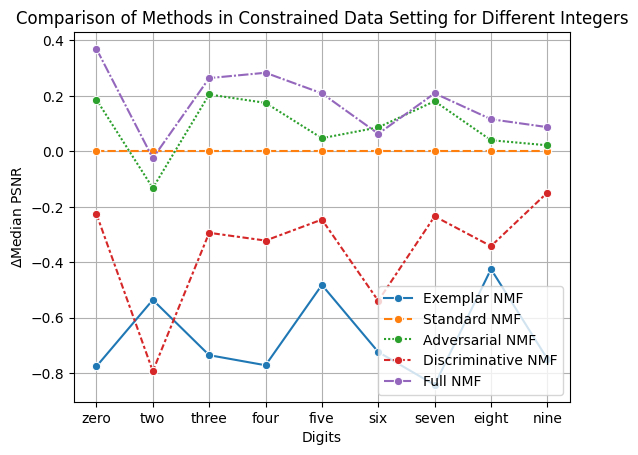

In [84]:
for i in range(len(data_poor_df)):
    data_poor_df["M"].loc[i] = i + (i>=1)
new_df = data_poor_df.copy(deep = True)
#
for column in new_df:
    if column != "M":
        new_df[column] = new_df[column] - data_poor_df["std"]
print(np.mean(new_df["std"]))
print(np.mean(new_df["adv"]))
print(np.mean(new_df["sup"]))
print(np.mean(new_df["full"]))
ax = seaborn.lineplot(data = new_df.drop("M", axis = 1), marker = 'o')
ax.set_xticklabels(['','zero', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
ax.set_xlabel("Digits")
ax.set_ylabel(r"$\Delta$" + "Median PSNR")
plt.title("Comparison of Methods in Constrained Data Setting for Different Integers")
plt.legend(labels = ["Exemplar NMF", "_nolegend_" , "Standard NMF", "_nolegend_", "Adversarial NMF", "_nolegend_", "Discriminative NMF", "_nolegend_", "Full NMF"], loc = "lower right")
plt.grid()
plt.savefig('fig/data_poor.pdf')
plt.show()
